In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

f = mtick.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))

from os import listdir, mkdir
from os.path import isdir
rcParams = {'font.size': 24 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal', 'xtick.labelsize':20,
            'ytick.labelsize':20,'axes.spines.right' : False,
            'axes.spines.top' : False}

import warnings
warnings.filterwarnings('ignore')

def Fit_Regression(df, xcol = 'Num_genes', ycol = 'Total_seqs_multi', logx = True, logy = True):
    x = np.array(df[xcol].tolist())
    y = np.array(df[ycol].tolist())
    y[y==0] = 1
    if logx:
        x = np.log10(x)
    if logy:
        y = np.log10(y)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    M = LinearRegression()
    M.fit(x, y)
    m = M.coef_[0][0]
    c = M.intercept_[0]
    y_ind = np.where(y != 0)[0]
    e = np.mean(np.abs(y[y_ind] - M.predict(x[y_ind]))/y[y_ind])*100
    r2 = r2_score(y, M.predict(x))
    return m, e, c, r2

def Plot_Box_Plots(boxes, positions, color, ax, widths = 0.45, lw = 3.5, 
                   scatter = True, deviation = 0.045, s = 70, alpha = 0.1):
    flierprops = dict(marker='x', markersize=0.5, linestyle='none')
    whiskerprops = dict(color='black',linewidth=1.5)
    capprops = dict(color='black', linewidth=0.5)
    medianprops = dict(linewidth=1.5, linestyle='-', color='black')
    box = ax.boxplot(boxes, positions=positions, whis = [2.5,97.5], widths = [widths]*len(positions),
                     showfliers = False, boxprops = dict(linestyle='-', linewidth=lw, color=color), 
                     flierprops = flierprops, whiskerprops = whiskerprops, capprops = capprops, 
                     medianprops = medianprops)
    
    if(scatter):
        for i in range(0, len(positions)):
            y = boxes[i]
            x = np.random.normal(positions[i], deviation, size=len(y))
            ax.scatter(x,y,color = color,alpha = alpha, marker = 'o', s = s)

In [2]:
data_path='/Users/harihara/Research-Activities/Data/Species_Boundary/Listeria/Markers/'
files = listdir(data_path)
df_fit = pd.DataFrame()
files.sort()

for fi in files:
    if fi.startswith(".") or fi.endswith(".zip"):
        continue
    genes = listdir(data_path+fi+"/")
    for g in genes:
        df = pd.read_csv(data_path+fi+"/"+g, sep = "\t")
        df['Frac_MSC'] = df['Species_in_multispecies']/df['Num_species']*100.0
        m,e, c, r2 = Fit_Regression(df)
        gene = g.replace("_results.txt.summary","").replace(".0.99","").replace(".0.97","").\
        replace(".0.95","").replace(".1.0","")
        df['Gene'] = gene
        df['m'] = m
        df['Error'] = e
        df['Similarity'] = fi
        df_fit = df_fit.append(df, ignore_index = True)    


In [3]:
data_path='/Users/harihara/Research-Activities/Data/Species_Boundary/Listeria/16S/'
for fi in listdir(data_path):
    if fi.startswith('.'): continue
        
    df = pd.read_csv(data_path+fi, sep = "\t")
    df['Frac_MSC'] = df['Species_in_multispecies']/df['Num_species']*100.0
    m,e,c,r2 = Fit_Regression(df)
    df['Gene'] = '16S rRNA'
    df['m'] = m
    df['Error'] = e
    
    if '0.99' in fi: s = '99'
    if '0.97' in fi: s = '97'
    if '0.95' in fi: s = '95'
    if '1.0' in fi: s = '100'
    df['Similarity'] = s
    df_fit = df_fit.append(df, ignore_index = True)
    

In [4]:
outdir = '/Users/harihara/Research-Activities/Plots/Species_Boundary/'
if not isdir(outdir):
    mkdir(outdir)

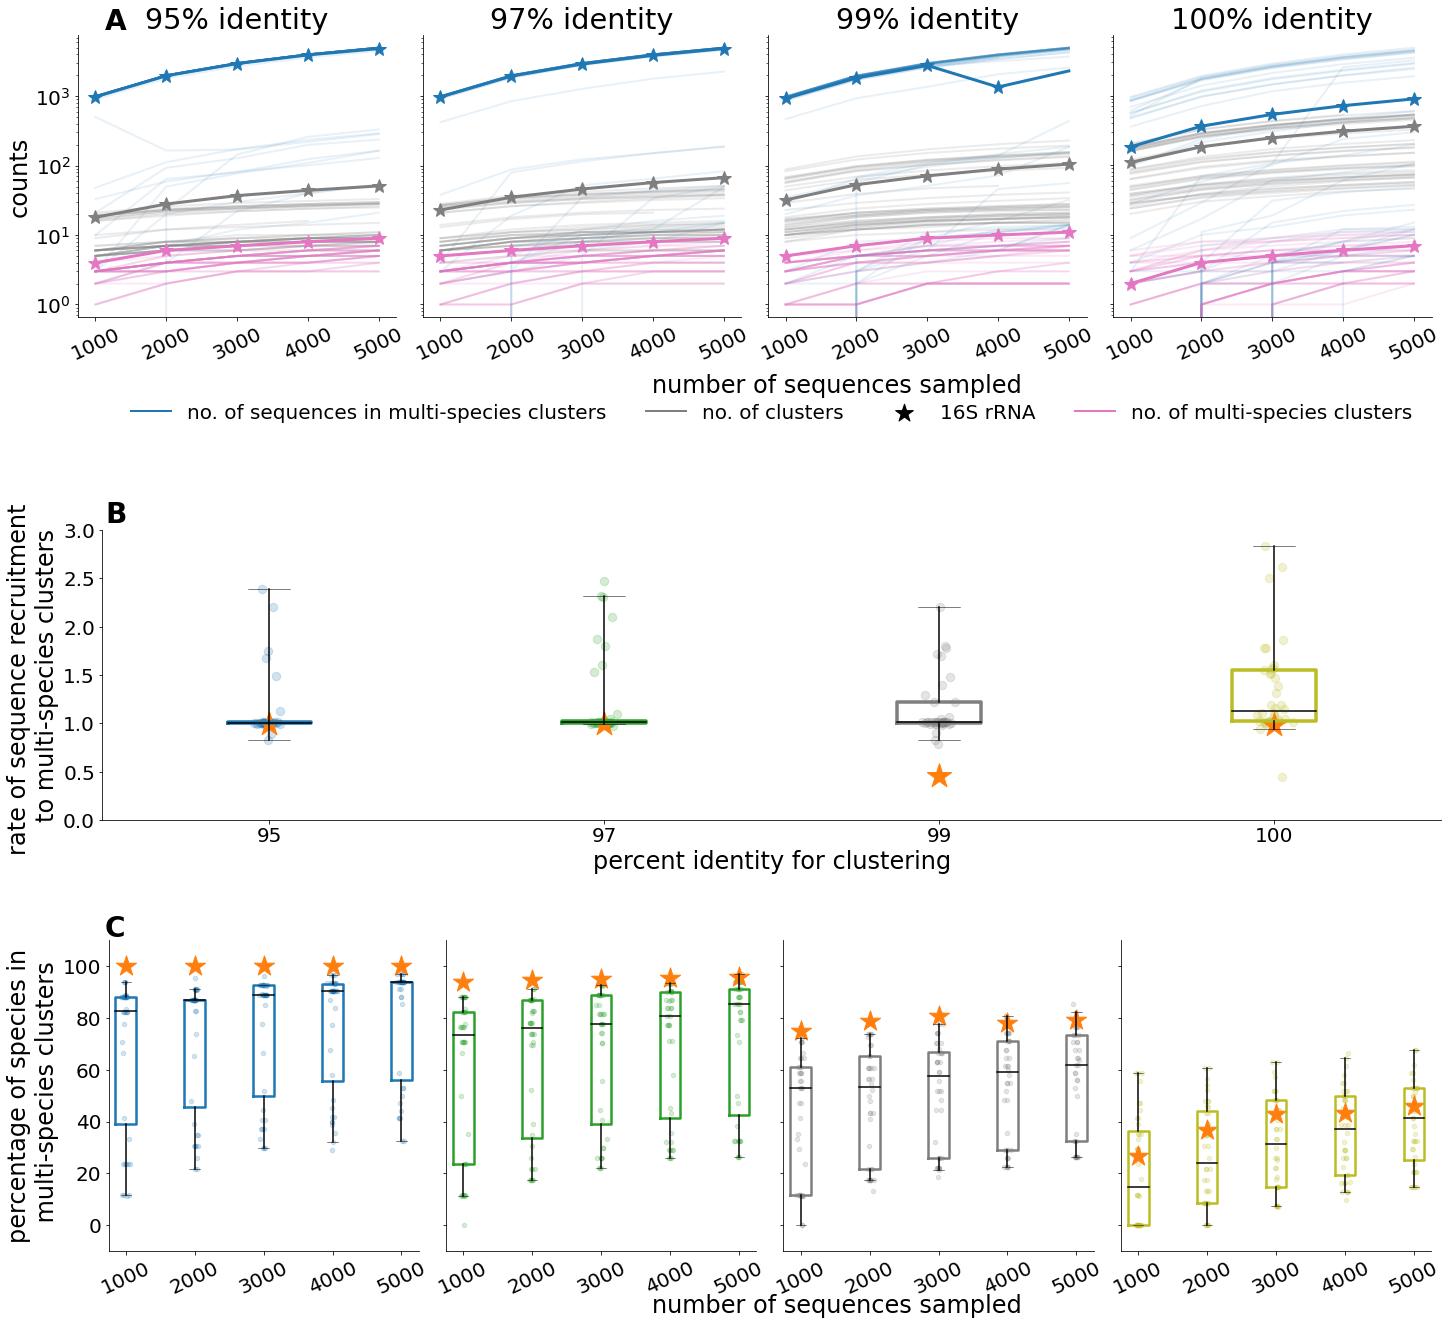

In [6]:
plt.rcParams.update(rcParams)

fig = plt.figure(constrained_layout = True,figsize = (20,18))
gs0 = fig.add_gridspec(6, 1,  height_ratios=[5,1.2,0.75,4,0.75,5])

gs1 = gs0[0].subgridspec(1, 4)
ax1, ax2, ax3, ax4 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1]), fig.add_subplot(gs1[2]), fig.add_subplot(gs1[3])
ax5  = fig.add_subplot(gs0[1])

ax_t = fig.add_subplot(gs0[2])
#ax_t.axhline(0.5, color = 'black')
ax_t.axis('off')

ax6 = fig.add_subplot(gs0[3])

ax_t = fig.add_subplot(gs0[4])
#ax_t.axhline(0.5, color = 'black')
ax_t.axis('off')

gs2 = gs0[5].subgridspec(1, 4)
ax7 = fig.add_subplot(gs2[0])
ax8 = fig.add_subplot(gs2[1])
ax9 = fig.add_subplot(gs2[2])
ax10 = fig.add_subplot(gs2[3])

colors = ['C0','C2','C7','C8']
similarities = ['95','97','99','100']

for i in range(len(similarities)) :
    df = df_fit[df_fit['Similarity'] == similarities[i]]
    Plot_Box_Plots([df.loc[(df['Gene'] != '16S rRNA')]['m'].unique()], [i+1], colors[i], ax6, widths = 0.25, 
                   deviation = 0.02, alpha = 0.2)
    ax6.scatter(i+1, df.loc[(df['Gene'] == '16S rRNA')]['m'].unique(), marker = '*', s = 650, color = 'C1')
ax6.set_ylim([0, 3.0])
ax6.set_ylabel('rate of sequence recruitment \nto multi-species clusters')
ax6.set_xticks([1,2,3,4])
ax6.set_xticklabels(similarities)
ax6.set_xlabel('percent identity for clustering')

genes = df_fit.Gene.unique()
genes.sort()
genes = genes[::-1]
database_sizes =  [1000, 2000, 3000, 4000, 5000]

ax = [ax1,ax2,ax3,ax4]
for i in range(0, len(similarities)):
    for gene in genes:
        try:
            df = df_fit[(df_fit['Similarity'] == similarities[i])&(df_fit['Gene'] == gene)]
            df = df.sort_values(by = 'Num_genes')
            
            if gene != '16S rRNA':
                ax[i].plot(df['Num_genes'],df['Total_seqs_multi'], color = 'C0', alpha = 0.1, 
                           linewidth = 2)
                #ax[i].plot(df['Num_genes'],df['Num_species'],  color = 'C1',
                #           linewidth = 2, alpha = 0.15)
                ax[i].plot(df['Num_genes'],df['Num_clusters'], color = 'C7',
                           linewidth = 2, alpha = 0.15)
                ax[i].plot(df['Num_genes'],df['Num_multispecies'], color = 'C6',
                           linewidth = 2, alpha = 0.15)
            
            if gene == '16S rRNA':
                ax[i].plot(df['Num_genes'],df['Total_seqs_multi'], linewidth = 3, 
                           marker = '*', markevery = 0.1, color = 'C0', ms = 15)
                #ax[i].plot(df['Num_genes'],df['Num_species'], markevery = 0.1,
                #           color = 'C1', linewidth = 3, marker = '*', ms = 15)
                ax[i].plot(df['Num_genes'],df['Num_clusters'], color = 'C7',
                           linewidth = 3, markevery = 0.1, ms = 15, marker = '*')
                ax[i].plot(df['Num_genes'],df['Num_multispecies'], color = 'C6',
                           linewidth = 3, markevery = 0.1, ms = 15, marker = '*')
                
        except KeyError:
            continue
        ax[i].semilogy()
        ax[i].set_xlim([750, 5250])
        ax[i].set_xticks(database_sizes)
        ax[i].set_xticklabels(['1000', '2000', '3000', '4000', '5000'], rotation = 25, fontsize = 20)
        ax[i].set_title(similarities[i]+'% identity')
        if i != 0:
            ax[i].set_yticklabels([])
ax[0].set_ylabel('counts')
ax[0].plot([-1, 1], color = 'C0', linewidth =2, label = 'no. of sequences in multi-species clusters')
#ax[0].plot([-1, 1], color = 'C1', linewidth =2, label='no. of species')
ax[0].plot([-1, 1], color = 'C7', linewidth =2, label = 'no. of clusters')
ax[0].scatter(-1, -1, marker = '*', s = 350, color = 'black', label = '16S rRNA')
ax[0].plot([-1, 1], color = 'C6', linewidth =2, label = 'no. of multi-species clusters')

fig.text(0.45, 0.7,'number of sequences sampled')

handles, labels = ax[0].get_legend_handles_labels()
ax5.legend(handles, labels, loc='center', ncol = 4, frameon = False, fontsize = 20)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.axis('off')

ax = [ax7, ax8, ax9, ax10]
for i in range(0, len(similarities)):
    box = []
    scatter = []
    for d in database_sizes:
        df = df_fit[(df_fit['Num_genes'] == d)&(df_fit['Similarity'] == similarities[i])]
        box.append(df.loc[(df['Gene']!='16S rRNA')]['Frac_MSC'].tolist())
        scatter += df.loc[(df['Gene']=='16S rRNA')]['Frac_MSC'].tolist()
    Plot_Box_Plots(box, database_sizes, colors[i], ax[i], widths = 300, scatter = True, s = 20, deviation=25, 
                   lw = 2.5, alpha = 0.2)
    ax[i].scatter(database_sizes, scatter, marker = '*', s = 450, color = 'C1')
    ax[i].set_xticks(database_sizes)
    ax[i].set_xticklabels(database_sizes, rotation = 45)
    ax[i].set_xlim(ax1.get_xlim())
    ax[i].set_ylim([-10, 110])
    if i != 0:
        ax[i].set_yticklabels([])
    ax[i].set_xticks(database_sizes)
    ax[i].set_xticklabels(['1000', '2000', '3000', '4000', '5000'], rotation = 25, fontsize = 20)

fig.text(0.45, -0.01,'number of sequences sampled')
ax[0].set_ylabel('percentage of species in\n multi-species clusters')

fig.text(0.07,0.980,'A', size = 28, weight = 'bold')
fig.text(0.07,0.600,'B', size = 28, weight = 'bold')
fig.text(0.07,0.28,'C', size = 28, weight = 'bold')

fig.savefig(outdir+'Figure-2.pdf',bbox_inches="tight")
fig.savefig(outdir+'Figure-2.png',bbox_inches="tight")
fig.savefig(outdir+'Figure-2.tiff',bbox_inches="tight")


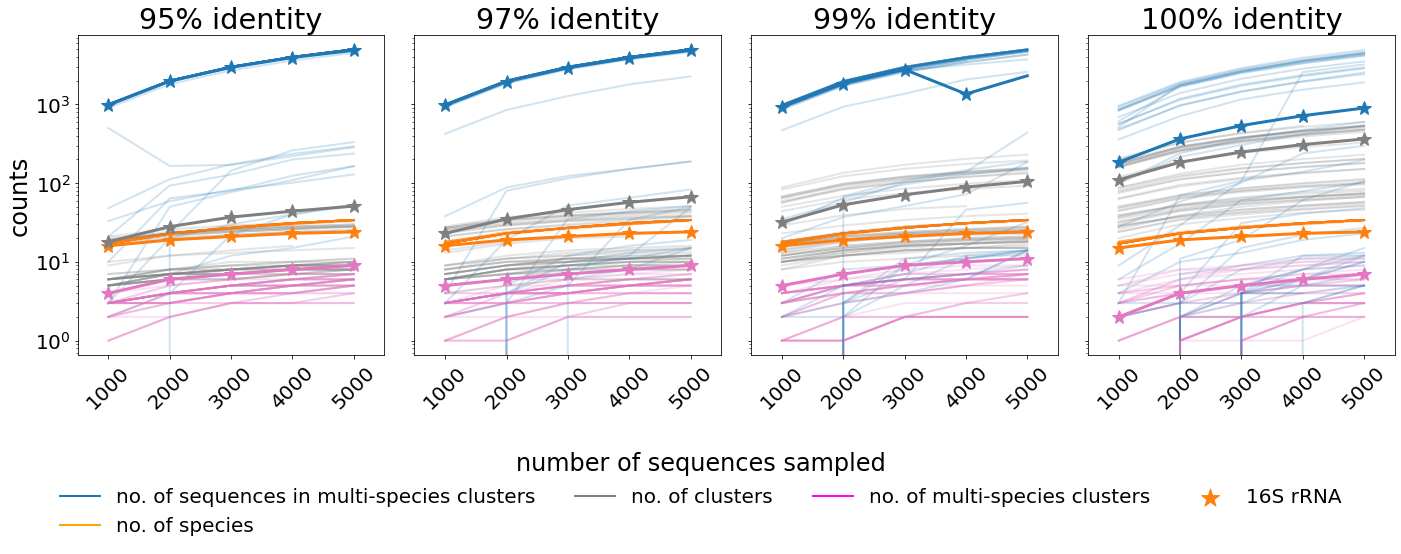

In [7]:
fig,ax = plt.subplots(1, 4, figsize = (20,8), sharey = True, sharex = True)
genes = df_fit.Gene.unique()
genes.sort()
genes = genes[::-1]

for i in range(0, len(similarities)):
    for gene in genes:
        try:
            df = df_fit[(df_fit['Similarity'] == similarities[i])&(df_fit['Gene'] == gene)]
            df = df.sort_values(by = 'Num_genes')
            
            if gene != '16S rRNA':
                ax[i].plot(df['Num_genes'].tolist(),df['Total_seqs_multi'].tolist(), color = 'C0', alpha = 0.2, 
                           linewidth = 2)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_species'].tolist(),  color = 'C1',
                           linewidth = 2, alpha = 0.2)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_clusters'].tolist(), color = 'C7',
                           linewidth = 2, alpha = 0.2)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_multispecies'].tolist(), color = 'C6',
                           linewidth = 2, alpha = 0.2)
            
            if gene == '16S rRNA':
                ax[i].plot(df['Num_genes'].tolist(),df['Total_seqs_multi'].tolist(), linewidth = 3, 
                           marker = '*', markevery = 0.1, color = 'C0', ms = 15)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_species'].tolist(), markevery = 0.1,
                           color = 'C1', linewidth = 3, marker = '*', ms = 15)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_clusters'].tolist(), color = 'C7',
                           linewidth = 3, markevery = 0.1, ms = 15, marker = '*')
                ax[i].plot(df['Num_genes'].tolist(),df['Num_multispecies'].tolist(), color = 'C6',
                           linewidth = 3, markevery = 0.1, ms = 15, marker = '*')
                
        except KeyError:
            continue
        ax[i].semilogy()
        ax[i].set_xticks([1000,2000,3000,4000,5000])
        ax[i].set_xlim(500, 5500)
        ax[i].set_xticklabels(['1000', '2000', '3000', '4000', '5000'], rotation = 45)
        ax[i].set_title(similarities[i]+'% identity')
ax[0].set_ylabel('counts')
ax[0].plot([-1, 1], color = 'C0', linewidth =2, label = 'no. of sequences in multi-species clusters')
ax[0].plot([-1, 1], color = 'orange', linewidth =2, label='no. of species')
ax[0].plot([-1, 1], color = 'grey', linewidth =2, label = 'no. of clusters')
ax[0].plot([-1, 1], color = 'magenta', linewidth =2, label = 'no. of multi-species clusters')
ax[0].scatter(-1, -1, marker = '*', s = 350, color = 'C1', label = '16S rRNA')

fig.text(0.5, 0.15, 'number of sequences sampled', ha='center')

fig.tight_layout()
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol = 4, frameon = False, fontsize = 20)
fig.subplots_adjust(bottom = 0.35)

fig.savefig(outdir+'Supplementary-Material-Fig-2.pdf')
fig.savefig(outdir+'Supplementary-Material-Fig-2.png')
fig.savefig(outdir+'Supplementary-Material-Fig-2.tiff')